In [1]:
import pyspark
from pyspark.sql import SparkSession

In [2]:
spark = SparkSession.builder.config("spark.driver.memory", "10g").appName("chapter8").getOrCreate()

24/01/03 14:14:51 WARN Utils: Your hostname, quangtn933.local resolves to a loopback address: 127.0.0.1; using 192.168.1.90 instead (on interface en0)
24/01/03 14:14:51 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/01/03 14:14:51 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## Preparting data

In [3]:
stocks = spark.read.csv("/Users/quangtn/Desktop/01_work/01_job/02_ml/PySpark/EstimateFinanceRisk/stocks/",header='true', inferSchema='true')

24/01/03 14:15:05 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


In [4]:
stocks.show(3)

+---------+-------+-------+-------+-------+------+
|     Date|   Open|   High|    Low|  Close|Volume|
+---------+-------+-------+-------+-------+------+
|31-Dec-13|1884.00|1900.00|1880.00| 1900.0|   546|
|30-Dec-13|1889.00|1900.00|1880.00| 1900.0|  1656|
|27-Dec-13|1880.00|1909.00|1880.00|1891.12|  1939|
+---------+-------+-------+-------+-------+------+
only showing top 3 rows



In [5]:
from pyspark.sql import functions as fun

In [6]:
stocks = stocks.withColumn("Symbol", fun.input_file_name()). \
            withColumn("Symbol", fun.element_at(fun.split("Symbol", "/"),-1)). \
            withColumn("Symbol", fun.element_at(fun.split("Symbol", "\."),1))

In [7]:
stocks.show(2)

+---------+-------+-------+-------+------+------+------+
|     Date|   Open|   High|    Low| Close|Volume|Symbol|
+---------+-------+-------+-------+------+------+------+
|31-Dec-13|1884.00|1900.00|1880.00|1900.0|   546|  CLDN|
|30-Dec-13|1889.00|1900.00|1880.00|1900.0|  1656|  CLDN|
+---------+-------+-------+-------+------+------+------+
only showing top 2 rows



In [8]:
factors = spark.read.csv("/Users/quangtn/Desktop/01_work/01_job/02_ml/PySpark/EstimateFinanceRisk/factors", header='true', inferSchema='true')

In [9]:
factors = factors.withColumn("Symbol", fun.input_file_name()).\
                withColumn("Symbol", fun.element_at(fun.split("Symbol", "/"), -1)).\
                withColumn("Symbol", fun.element_at(fun.split("Symbol", "\."), 1))

In [10]:
from pyspark.sql import Window

In [11]:
stocks = stocks.withColumn('count', fun.count('Symbol').over(Window.partitionBy('Symbol'))).\
                filter(fun.col('count') > 260*5+10)

In [21]:
spark.sql("set spark.sql.legacy.timeParserPolicy=LEGACY")

DataFrame[key: string, value: string]

In [22]:
stocks.printSchema()

root
 |-- Date: date (nullable = true)
 |-- Open: string (nullable = true)
 |-- High: string (nullable = true)
 |-- Low: string (nullable = true)
 |-- Close: double (nullable = true)
 |-- Volume: string (nullable = true)
 |-- Symbol: string (nullable = true)
 |-- count: long (nullable = false)



In [23]:
stocks.show(2)

+----------+-----+-----+-----+-----+---------+------+-----+
|      Date| Open| High|  Low|Close|   Volume|Symbol|count|
+----------+-----+-----+-----+-----+---------+------+-----+
|2013-10-23|74.14|75.10|74.14|74.99| 78431122|  AAPL| 3520|
|2013-10-22|75.20|75.49|72.58|74.27|133515753|  AAPL| 3520|
+----------+-----+-----+-----+-----+---------+------+-----+
only showing top 2 rows



In [24]:
from datetime import datetime

In [25]:
stocks = stocks.withColumn('Date', fun.to_date(fun.to_timestamp(fun.col('Date'), 'dd-MMM-yy')))

In [26]:
stocks = stocks.filter(fun.col('Date') >= datetime(2009, 10, 23)).\
                filter(fun.col('Date') <= datetime(2013, 10, 23))

In [27]:
factors = factors.withColumn('Date', fun.to_date(fun.to_timestamp(fun.col('Date'),\
                            'dd-MMM-yy')))

In [28]:
factors.show(2)

+----------+------+------+------+------+-------+--------------+
|      Date|  Open|  High|   Low| Close| Volume|        Symbol|
+----------+------+------+------+------+-------+--------------+
|2013-12-31|102.29|102.55|101.17|101.86|7219195|NASDAQ%253ATLT|
|2013-12-30|102.15|102.58|102.08|102.51|4491711|NASDAQ%253ATLT|
+----------+------+------+------+------+-------+--------------+
only showing top 2 rows



In [29]:
factors = factors.filter(fun.col('Date') >= datetime(2009, 10, 23)).\
                filter(fun.col('Date') <= datetime(2014, 10, 23))

In [30]:
factors.show(3)

+----------+------+------+------+------+-------+--------------+
|      Date|  Open|  High|   Low| Close| Volume|        Symbol|
+----------+------+------+------+------+-------+--------------+
|2013-12-31|102.29|102.55|101.17|101.86|7219195|NASDAQ%253ATLT|
|2013-12-30|102.15|102.58|102.08|102.51|4491711|NASDAQ%253ATLT|
|2013-12-27|102.07|102.31|101.69|101.81|4755262|NASDAQ%253ATLT|
+----------+------+------+------+------+-------+--------------+
only showing top 3 rows



In [31]:
stocks_pd_df = stocks.toPandas()

In [32]:
stocks_pd_df.head(5)

,Date,Open,High,Low,Close,Volume,Symbol,count
0,2013-10-23,74.14,75.10,74.14,74.99,78431122,AAPL,3520
1,2013-10-22,75.20,75.49,72.58,74.27,133515753,AAPL,3520
2,2013-10-21,73.11,74.90,73.07,74.48,99526945,AAPL,3520
3,2013-10-18,72.28,72.75,72.24,72.70,72635570,AAPL,3520
4,2013-10-17,71.43,72.11,71.38,72.07,63398335,AAPL,3520


In [33]:
factors_pd_df = factors.toPandas()

In [34]:
factors_pd_df.head(5)

,Date,Open,High,Low,Close,Volume,Symbol
0,2013-12-31,102.29,102.55,101.17,101.86,7219195,NASDAQ%253ATLT
1,2013-12-30,102.15,102.58,102.08,102.51,4491711,NASDAQ%253ATLT
2,2013-12-27,102.07,102.31,101.69,101.81,4755262,NASDAQ%253ATLT
3,2013-12-26,102.35,102.36,102.01,102.10,4645323,NASDAQ%253ATLT
4,2013-12-24,103.23,103.35,102.80,102.83,4897009,NASDAQ%253ATLT


## Determining the Factor Weights

In [35]:
n_steps=10
def my_fun(x):
    return ((x.iloc[-1] -x.iloc[0]) / x.iloc[0])

In [37]:
stock_returns = stocks_pd_df.groupby('Symbol').Close.rolling(window=n_steps).apply(my_fun)

In [38]:
stock_returns.head(5)

Symbol         
AAME    1514540   NaN
        1514541   NaN
        1514542   NaN
        1514543   NaN
        1514544   NaN
Name: Close, dtype: float64

In [40]:
factors_returns = factors_pd_df.groupby('Symbol').Close.rolling(window=n_steps).apply(my_fun)

In [41]:
factors_returns

Symbol                
NASDAQ%253ATLT    0            NaN
                  1            NaN
                  2            NaN
                  3            NaN
                  4            NaN
                            ...   
NYSEARCA%253AGLD  2101   -0.063047
                  2102   -0.070671
                  2103   -0.058601
                  2104   -0.051848
                  2105   -0.032623
Name: Close, Length: 3159, dtype: float64

In [42]:
stock_returns = stock_returns.reset_index().sort_values('level_1').reset_index()

In [43]:
factors_returns = factors_returns.reset_index().sort_values('level_1').reset_index()

In [44]:
stocks_pd_df_with_returns = stocks_pd_df.assign(stocks_returns=stock_returns['Close'])

In [46]:
stocks_pd_df_with_returns

,Date,Open,High,Low,Close,Volume,Symbol,count,stocks_returns
0,2013-10-23,74.14,75.10,74.14,74.99,78431122,AAPL,3520,NaN
1,2013-10-22,75.20,75.49,72.58,74.27,133515753,AAPL,3520,NaN
2,2013-10-21,73.11,74.90,73.07,74.48,99526945,AAPL,3520,NaN
3,2013-10-18,72.28,72.75,72.24,72.70,72635570,AAPL,3520,NaN
4,2013-10-17,71.43,72.11,71.38,72.07,63398335,AAPL,3520,NaN
...,...,...,...,...,...,...,...,...,...
1770088,2009-10-29,25.41,25.54,25.10,25.26,146595,ZBRA,3520,-0.068241
1770089,2009-10-28,25.46,25.63,25.16,25.23,381677,ZBRA,3520,-0.054348
1770090,2009-10-27,25.46,25.72,25.20,25.39,212442,ZBRA,3520,-0.036067
1770091,2009-10-26,25.55,25.78,25.19,25.47,204426,ZBRA,3520,-0.024138


In [47]:
factors_pd_df_with_returns = factors_pd_df.assign(factors_returns=factors_returns['Close'],\
                    factors_returns_squared=factors_returns['Close']**2)

In [49]:
factors_pd_df_with_returns = factors_pd_df_with_returns.pivot(index='Date',\
            columns='Symbol', values=['factors_returns', 'factors_returns_squared'])


In [50]:
factors_pd_df_with_returns.columns = factors_pd_df_with_returns.columns.to_series().\
            str.join('_').reset_index()[0]

In [51]:
factors_pd_df_with_returns = factors_pd_df_with_returns.reset_index()

In [52]:
factors_pd_df_with_returns.head(5)

,Date,factors_returns_NASDAQ%253ATLT,factors_returns_NYSEARCA%253ACRED,factors_returns_NYSEARCA%253AGLD,factors_returns_squared_NASDAQ%253ATLT,factors_returns_squared_NYSEARCA%253ACRED,factors_returns_squared_NYSEARCA%253AGLD
0,2009-10-23,0.018340,-0.006594,-0.032623,0.000336,0.000043,0.001064
1,2009-10-26,0.004179,-0.009727,-0.051848,0.000017,0.000095,0.002688
2,2009-10-27,0.016695,-0.001771,-0.058601,0.000279,0.000003,0.003434
3,2009-10-28,0.023373,0.001873,-0.070671,0.000546,0.000004,0.004994
4,2009-10-29,0.008008,-0.001277,-0.063047,0.000064,0.000002,0.003975


In [56]:
from sklearn.linear_model import LinearRegression
import pandas as pd

In [57]:
stocks_factors_combined_df = pd.merge(stocks_pd_df_with_returns, factors_pd_df_with_returns,\
                                    how="left", on="Date")

In [58]:
stocks_factors_combined_df.head(5)

,Date,Open,High,Low,Close,Volume,Symbol,count,stocks_returns,factors_returns_NASDAQ%253ATLT,factors_returns_NYSEARCA%253ACRED,factors_returns_NYSEARCA%253AGLD,factors_returns_squared_NASDAQ%253ATLT,factors_returns_squared_NYSEARCA%253ACRED,factors_returns_squared_NYSEARCA%253AGLD
0,2013-10-23,74.14,75.10,74.14,74.99,78431122,AAPL,3520,NaN,0.031327,0.011085,0.016830,0.000981,0.000123,2.832476e-04
1,2013-10-22,75.20,75.49,72.58,74.27,133515753,AAPL,3520,NaN,0.015053,0.006313,0.019951,0.000227,0.000040,3.980467e-04
2,2013-10-21,73.11,74.90,73.07,74.48,99526945,AAPL,3520,NaN,0.004803,0.003623,0.000236,0.000023,0.000013,5.584407e-08
3,2013-10-18,72.28,72.75,72.24,72.70,72635570,AAPL,3520,NaN,-0.005574,-0.003138,-0.006967,0.000031,0.000010,4.854295e-05
4,2013-10-17,71.43,72.11,71.38,72.07,63398335,AAPL,3520,NaN,-0.005586,-0.003601,-0.016821,0.000031,0.000013,2.829456e-04


In [59]:
feature_columns = list(stocks_factors_combined_df.columns[-6:])

In [60]:
feature_columns

['factors_returns_NASDAQ%253ATLT',
 'factors_returns_NYSEARCA%253ACRED',
 'factors_returns_NYSEARCA%253AGLD',
 'factors_returns_squared_NASDAQ%253ATLT',
 'factors_returns_squared_NYSEARCA%253ACRED',
 'factors_returns_squared_NYSEARCA%253AGLD']

In [70]:
with pd.option_context('mode.use_inf_as_na', True):
    stocks_factors_combined_df=stocks_factors_combined_df.dropna(subset=feature_columns\
                                                                    + ['stocks_returns'])

In [73]:
def find_ols_coef(df):
    y = df[['stocks_returns']].values
    X = df[feature_columns]

    regr = LinearRegression()
    regr_output = regr.fit(X, y)

    return list(df[['Symbol']].values[0])+ list(regr_output.coef_[0])

In [90]:
coefs_per_stocks = stocks_factors_combined_df.groupby('Symbol').apply(find_ols_coef)

In [91]:
coefs_per_stocks = pd.DataFrame(coefs_per_stocks).reset_index()

In [92]:
coefs_per_stocks.head(5)

,Symbol,0
0,AAME,"[AAME, -0.36078742852174495, -0.16561535388279..."
1,AAON,"[AAON, -1.320765057167287, 1.5821356187324118,..."
2,AAPL,"[AAPL, -0.938763395577243, 1.318915471652033, ..."
3,AAWW,"[AAWW, -2.1150491780790555, 3.2843088904530675..."
4,AAXJ,"[AAXJ, -1.2566753468241727, 2.3519385401414037..."


In [93]:
coefs_per_stocks.columns = ['symbol', 'factor_coef_list']

In [94]:
coefs_per_stocks = pd.DataFrame(coefs_per_stocks.factor_coef_list.tolist(),\
                index=coefs_per_stocks.index, columns=['Symbol']+feature_columns)

In [95]:
coefs_per_stocks.head(5)

,Symbol,factors_returns_NASDAQ%253ATLT,factors_returns_NYSEARCA%253ACRED,factors_returns_NYSEARCA%253AGLD,factors_returns_squared_NASDAQ%253ATLT,factors_returns_squared_NYSEARCA%253ACRED,factors_returns_squared_NYSEARCA%253AGLD
0,AAME,-0.360787,-0.165615,0.041222,4.273613,-20.505742,1.833947
1,AAON,-1.320765,1.582136,-0.013679,5.034547,-16.690021,-0.978665
2,AAPL,-0.938763,1.318915,0.415050,-0.207201,23.813545,-0.804982
3,AAWW,-2.115049,3.284309,0.343610,10.474248,-77.580492,0.334246
4,AAXJ,-1.256675,2.351939,0.310289,4.557003,16.988597,-1.045195


In [96]:
samples = factors_returns.loc[factors_returns.Symbol == factors_returns.Symbol.unique()[0]]['Close']

<Axes: ylabel='Density'>

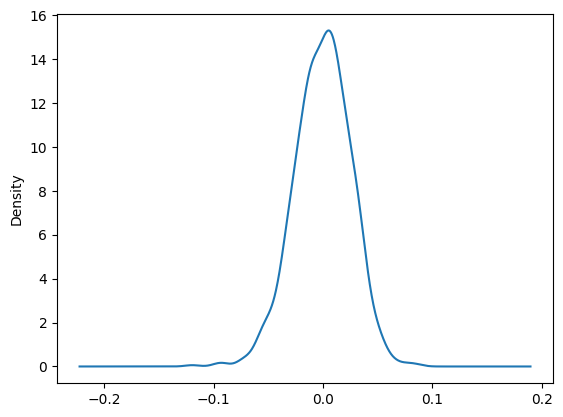

In [97]:
samples.plot.kde()

In [98]:
f_1 = factors_returns.loc[factors_returns.Symbol==factors_returns.Symbol.unique()[0]]['Close']
f_2 = factors_returns.loc[factors_returns.Symbol==factors_returns.Symbol.unique()[1]]['Close']
f_3 = factors_returns.loc[factors_returns.Symbol==factors_returns.Symbol.unique()[2]]['Close']

In [105]:
print(len(list(f_1)), len(list(f_2)), len(list(f_3)))
list_f1 = len(list(f_1))
list_f2 = len(list(f_2))
list_f3 = len(list(f_3))
pd.DataFrame({'f1':list(f_1), 'f2':list(f_2)[:list_f1], 'f3':list(f_3)[:list_f1]}).corr()

1052 1054 1053


,f1,f2,f3
f1,1.000000,0.074578,0.530550
f2,0.074578,1.000000,0.206538
f3,0.530550,0.206538,1.000000


In [107]:
factors_returns_cov = pd.DataFrame({'f1': list(f_1),
                                    'f2': list(f_2)[:list_f1],
                                    'f3': list(f_3)[:list_f1]}).cov().to_numpy()

In [110]:
factors_returns_mean = pd.DataFrame({'f1': list(f_1),
                                    'f2': list(f_2)[:list_f1],
                                    'f3': list(f_3)[:list_f1]}).mean()

In [111]:
from numpy.random import multivariate_normal

In [112]:
multivariate_normal(factors_returns_mean, factors_returns_cov)

array([0.00535115, 0.07209566, 0.00060792])

## Running the Trials

In [113]:
from pyspark.sql.types import IntegerType

parallelism = 1000
num_trials = 1000000
base_seed = 1496

In [114]:
seeds = [b for b in range(base_seed, base_seed+ parallelism)]
seedsDF = spark.createDataFrame(seeds, IntegerType())
seedsDF = seedsDF.repartition(parallelism)

In [116]:
b_coefs_per_stock = spark.sparkContext.broadcast(coefs_per_stocks)
b_feature_columns = spark.sparkContext.broadcast(feature_columns)
b_factors_returns_mean = spark.sparkContext.broadcast(factors_returns_mean)
b_factors_returns_cov = spark.sparkContext.broadcast(factors_returns_cov)

In [134]:
import random
from numpy.random import seed

from pyspark.sql.types import LongType, ArrayType, DoubleType
from pyspark.sql.functions import udf

def calculate_trial_return(x):
    trial_return_list = []

    for i in range(int(num_trials/parallelism)):
        random_int = random.randint(0, num_trials*num_trials)
        seed(x)

        random_factors = multivariate_normal(b_factors_returns_mean.value,
                        b_factors_returns_cov.value)

        coefs_per_stock_df = b_coefs_per_stock.value
        returns_per_stock = (coefs_per_stock_df[b_feature_columns.value] *\
            (list(random_factors) + list(random_factors**2)))
        
        trial_return_list.append(float(returns_per_stock.sum(axis=1).sum()/b_coefs_per_stock.value.size))
    return trial_return_list    

In [135]:
udf_return = udf(calculate_trial_return, ArrayType(DoubleType()))

In [136]:
from pyspark.sql.functions import col, explode

In [137]:
trials = seedsDF.withColumn("trial_return", udf_return(col("value")))

In [138]:
trials = trials.select("value", explode('trial_return').alias('trial_return'))

In [139]:
trials.cache()

DataFrame[value: int, trial_return: double]

In [140]:
trials.approxQuantile('trial_return', [0.05], 0.0)

[-0.022576795788500335]

In [144]:
trials.orderBy(col('trial_return').asc()).limit(int(trials.count()/20)).agg(fun.avg(col("trial_return"))).show()

+--------------------+
|   avg(trial_return)|
+--------------------+
|-0.03008066140295...|
+--------------------+

